<a href="https://colab.research.google.com/github/26medias/Stock-Picker/blob/master/Stock_picker_with_trend_detection_1.17_sharpe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Picker + Rolling Sim

## How it works

- Downloader: The class that handles download/caching of the price data
- Picker: The class that picks stocks based on current prices
- Order: The class that converts stock picks into a market order
- Portfolio: The class that handles the current portfolio and their values (broker sim)
- Sim: The main class that runs the sim and invokes all the other classes

## Imports

In [1]:
!wget https://datahub.io/core/s-and-p-500-companies/r/constituents.csv
!pip install yfinance
!pip install pandas_ta

--2020-10-13 18:19:32--  https://datahub.io/core/s-and-p-500-companies/r/constituents.csv
Resolving datahub.io (datahub.io)... 172.67.157.38, 104.18.48.253, 104.18.49.253, ...
Connecting to datahub.io (datahub.io)|172.67.157.38|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://pkgstore.datahub.io/core/s-and-p-500-companies/constituents_csv/data/652de3c89c39dafdee912fd9cfb23c21/constituents_csv.csv [following]
--2020-10-13 18:19:33--  https://pkgstore.datahub.io/core/s-and-p-500-companies/constituents_csv/data/652de3c89c39dafdee912fd9cfb23c21/constituents_csv.csv
Resolving pkgstore.datahub.io (pkgstore.datahub.io)... 104.18.48.253, 172.67.157.38, 104.18.49.253, ...
Connecting to pkgstore.datahub.io (pkgstore.datahub.io)|104.18.48.253|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19096 (19K) [text/csv]
Saving to: ‘constituents.csv’

constituents.csv    100%[===================>]  18.65K  --.-KB/s    in 0.003s  

2020-10-13 

In [2]:
import sys
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.cluster.hierarchy as spc

import hashlib

import pandas_ta as ta

from os import path
import json
from scipy import stats as scipy_stats
import threading
import time
import math
import random
from IPython.display import HTML, display
import ipywidgets as widgets


pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

## Classes

### Downloader

Returns:
- data
- prices
- returns
- sector_mean

How to use:
```
downloader = Downloader()
downloader.download()
```

In [3]:
class Downloader:
  def __init__(self, figsize=(30,10)):
    self.figsize  = figsize
    self.getStocklist()

  def getStocklist(self):
    self.stocklist = pd.read_csv('constituents.csv')
    self.symbols   = list(self.stocklist[['Symbol']].values.flatten())
    self.sectors   = self.stocklist['Sector'].unique()
  
  def stats(self):
    return self.stocklist.groupby('Sector').aggregate(['count'])
  
  def download(self, sector=None, symbols=None, period='1y'):
    print("Download: ", sector, symbols)
    if sector is not None:
      self.sector = sector
      rows      = self.stocklist[self.stocklist['Sector']==sector]
      symbols   = list(rows[['Symbol']].values.flatten())
      filename  = sector+'.pkl'
      self.symbols = self.getSymbolsBySector(self.sector)
    else:
      if symbols is not None:
        self.symbols = symbols
      filename  = 'data_'+period+'_'+(hashlib.sha224((''.join(self.symbols)).encode('utf-8')).hexdigest())+".json"
    
    if path.exists(filename):
      print("Using cached data")
      self.data = pd.read_pickle(filename)
    else:
      print("Downloading the historical prices")
      self.data = yf.download(self.symbols, period=period, threads=True)
      self.data.to_pickle(filename)
    #self.data = self.data.dropna()
    self.data = self.data[~self.data.index.duplicated(keep='last')]
    self.build()

    return self.data
  
  def getSymbolsBySector(self, sector):
    sectorRows    = self.stocklist[self.stocklist['Sector']==sector]
    return list(sectorRows[['Symbol']].values.flatten())
  
  def build(self):
    self.prices = self.data.loc[:,('Adj Close', slice(None))]
    if math.isnan(self.prices.iloc[0].max()):
      self.data = self.data.iloc[1:]
      self.prices = self.data.loc[:,('Adj Close', slice(None))]
    self.prices.columns = self.symbols
    self.changes  = (self.prices-self.prices.shift())/self.prices.shift()
    self.returns  = (self.prices[:]-self.prices[:].loc[list(self.prices.index)[0]])/self.prices[:].loc[list(self.prices.index)[0]]
    self.sector_mean = self.returns[self.symbols].T.describe().T[['mean']]
    return self.stocklist.groupby('Sector').aggregate(['count'])

downloader = Downloader()
downloader.download()

Download:  None None
[*********************100%***********************]  505 of 505 completed

2 Failed downloads:
- BF.B: No data found for this date range, symbol may be delisted
- BRK.B: No data found, symbol may be delisted


Adj Close                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

### Trading Zones


How to use:
```
zt = TradingZones(prices=downloader.prices)
zones = zt.get()
```

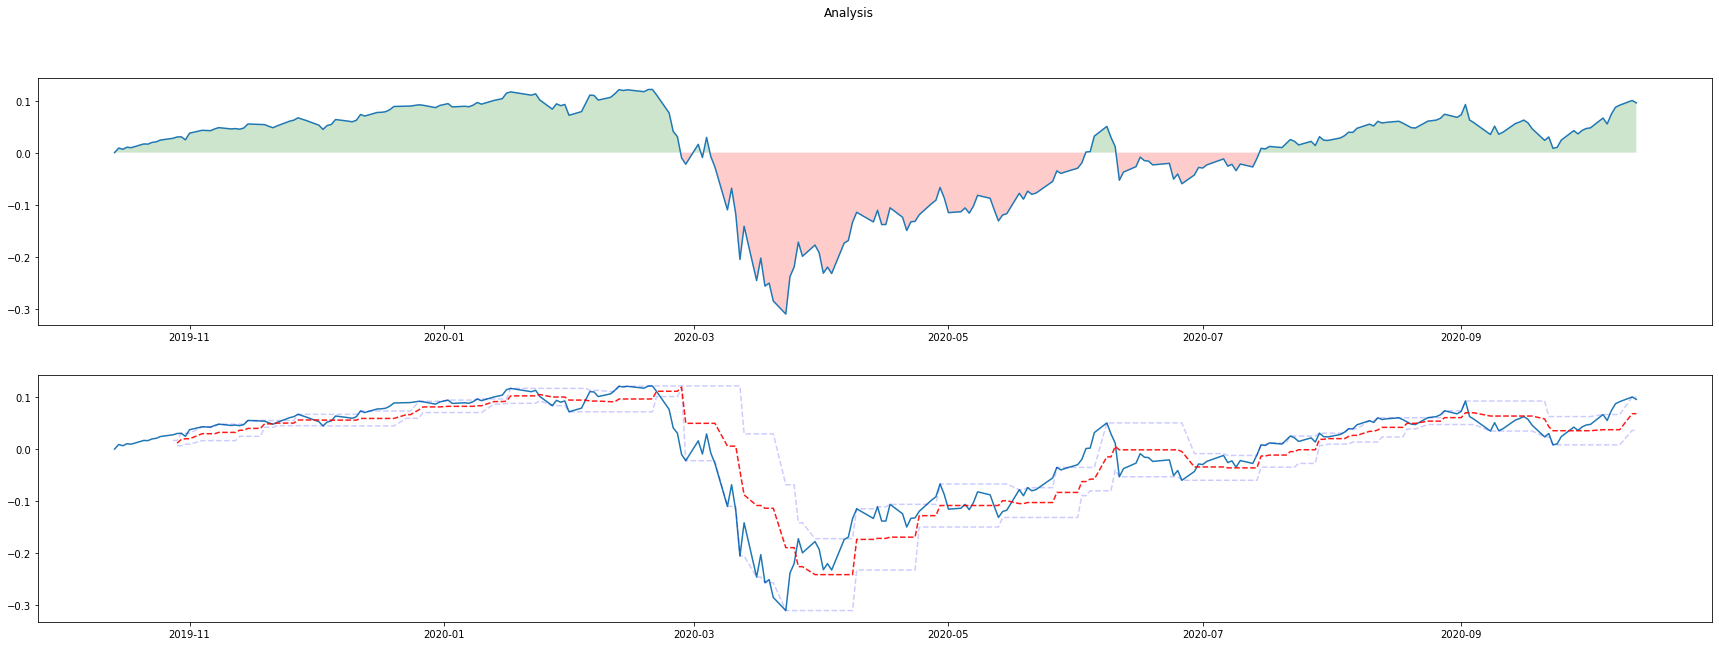

,mean,3d,7d,zone,resistances,supports,band_up,band_down,band_mean,signal
2020-08-04,0.032493,0.008560,0.017756,0.013158,0.030639,0.023402,0.030639,0.009673,0.020156,UP
2020-08-05,0.039252,0.015850,0.017687,0.016768,0.039252,0.023402,0.039252,0.009673,0.024463,UP
2020-08-06,0.038842,0.010668,0.025195,0.017931,0.039252,0.038842,0.039252,0.013647,0.026450,UP
2020-08-07,0.046776,0.014282,0.016136,0.015209,0.039252,0.038842,0.039252,0.013647,0.026450,UP
2020-08-10,0.054732,0.015480,0.030799,0.023139,0.054732,0.038842,0.054732,0.013647,0.034190,UP
2020-08-11,0.051242,0.012399,0.027839,0.020119,0.054732,0.051242,0.054732,0.013647,0.034190,UP
2020-08-12,0.060272,0.013496,0.032098,0.022797,0.060272,0.051242,0.060272,0.013647,0.036960,UP
2020-08-13,0.056927,0.002195,0.024433,0.013314,0.060272,0.056927,0.060272,0.023402,0.041837,UP
2020-08-14,0.058153,0.006912,0.018901,0.012906,0.060272,0.056927,0.060272,0.023402,0.041837,UP
2020-08-17,0.060301,0.000029,0.021459,0.010744,0.060301,0.056927,0.060301,0.023402,0.041852,UP


In [4]:
class TradingZones:
  def __init__(self, prices):
    self.prices = prices
    self.returns  = (self.prices[:]-self.prices[:].loc[list(self.prices.index)[0]])/self.prices[:].loc[list(self.prices.index)[0]]
  
  def get(self):
    self.stats = pd.DataFrame()
    self.stats['mean'] = self.returns.copy().T.mean().T
    #self.stats['mean'] = self.returns.copy().diff().T.mean().T
    self.stats['3d'] = self.stats['mean']-self.stats['mean'].shift(3)
    self.stats['7d'] = self.stats['mean']-self.stats['mean'].shift(7)
    self.stats['zone'] = (self.stats['7d']+self.stats['3d'])/2
    
    self.stats['resistances']  = self.stats[(self.stats['mean'].shift(1) < self.stats['mean']) & (self.stats['mean'].shift(-1) < self.stats['mean'])]['mean']
    self.stats['supports']     = self.stats[(self.stats['mean'].shift(1) > self.stats['mean']) & (self.stats['mean'].shift(-1) > self.stats['mean'])]['mean']
    self.stats = self.stats.ffill(axis = 0) 
    self.stats['band_up']      = self.stats['resistances'].rolling(10).max()
    self.stats['band_down']    = self.stats['supports'].rolling(10).min()
    self.stats['band_mean']    = (self.stats['band_up']+self.stats['band_down'])/2
    self.stats.at[self.stats[self.stats['mean'] > self.stats['band_mean']].index, 'signal'] = 'UP'
    self.stats.at[self.stats[self.stats['mean'] < self.stats['band_mean']].index, 'signal'] = 'DOWN'

    return self.stats
  
  def chart3(self):
    zones = self.stats
    fig, axs = plt.subplots(3, figsize=(30,10))
    fig.suptitle('Analysis')
    axs[0].plot(zones['mean'])
    axs[0].plot(zones['mean'].rolling(5).mean())
    axs[0].plot(zones['mean'].shift(5).rolling(5).mean())
    osc = zones['mean'].rolling(5).mean()-zones['mean'].shift(5).rolling(5).mean()
    
    axs[0].fill_between(zones.index, 0, zones['mean'], where=zones['zone'] >= 0, facecolor='green', interpolate=True, alpha=0.2)
    axs[0].fill_between(zones.index, 0, zones['mean'], where=zones['zone'] <= 0, facecolor='red', interpolate=True, alpha=0.2)

    axs[1].plot(zones['3d'])
    axs[1].plot(zones['7d'])
    axs[1].plot(zones['zone'])
    axs[1].fill_between(zones.index, 0, zones['zone'], where=zones['zone'] > 0, facecolor='green', interpolate=True, alpha=0.2)
    axs[1].fill_between(zones.index, 0, zones['zone'], where=zones['zone'] < 0, facecolor='red', interpolate=True, alpha=0.2)
    axs[2].fill_between(osc.index, 0, osc, where=osc > 0, facecolor='green', interpolate=True, alpha=0.2)
    axs[2].fill_between(osc.index, 0, osc, where=osc < 0, facecolor='red', interpolate=True, alpha=0.2)
    axs[2].plot(osc)
    plt.show()
  
  def chart2(self):
    zones = self.stats
    zones['osc'] = zones['mean'].rolling(5).mean()-zones['mean'].shift(5).rolling(5).mean()

    fig, axs = plt.subplots(3, figsize=(30,10))
    fig.suptitle('Analysis')
    axs[0].plot(zones['mean'])
    
    axs[0].fill_between(zones.index, 0, zones['mean'], where=zones['zone'] >= 0, facecolor='green', interpolate=True, alpha=0.2)
    axs[0].fill_between(zones.index, 0, zones['mean'], where=zones['zone'] <= 0, facecolor='red', interpolate=True, alpha=0.2)

    axs[1].plot(zones['3d'])
    axs[1].plot(zones['7d'])
    axs[1].plot(zones['zone'])
    axs[1].fill_between(zones.index, 0, zones['zone'], where=zones['zone'] > 0, facecolor='green', interpolate=True, alpha=0.2)
    axs[1].fill_between(zones.index, 0, zones['zone'], where=zones['zone'] < 0, facecolor='red', interpolate=True, alpha=0.2)
    
    axs[2].fill_between(zones['osc'].index, 0, zones['osc'], where=zones['osc'] > 0, facecolor='green', interpolate=True, alpha=0.2)
    axs[2].fill_between(zones['osc'].index, 0, zones['osc'], where=zones['osc'] < 0, facecolor='red', interpolate=True, alpha=0.2)
    axs[2].plot(zones['osc'])
    plt.show()
    zones = self.stats
    fig, axs = plt.subplots(3, figsize=(30,10))
    fig.suptitle('Analysis')
    axs[0].plot(zones['mean'])
    axs[0].plot(zones['mean'].rolling(5).mean())
    axs[0].plot(zones['mean'].shift(5).rolling(5).mean())
    osc = zones['mean'].rolling(5).mean()-zones['mean'].shift(5).rolling(5).mean()
    
    axs[0].fill_between(zones.index, 0, zones['mean'], where=zones['zone'] >= 0, facecolor='green', interpolate=True, alpha=0.2)
    axs[0].fill_between(zones.index, 0, zones['mean'], where=zones['zone'] <= 0, facecolor='red', interpolate=True, alpha=0.2)

    axs[1].plot(zones['3d'])
    axs[1].plot(zones['7d'])
    axs[1].plot(zones['zone'])
    axs[1].fill_between(zones.index, 0, zones['zone'], where=zones['zone'] > 0, facecolor='green', interpolate=True, alpha=0.2)
    axs[1].fill_between(zones.index, 0, zones['zone'], where=zones['zone'] < 0, facecolor='red', interpolate=True, alpha=0.2)
    axs[2].fill_between(osc.index, 0, osc, where=osc > 0, facecolor='green', interpolate=True, alpha=0.2)
    axs[2].fill_between(osc.index, 0, osc, where=osc < 0, facecolor='red', interpolate=True, alpha=0.2)
    axs[2].plot(osc)
    plt.show()
  
  def chart(self):
    zones = self.stats.copy()

    fig, axs = plt.subplots(2, figsize=(30,10))
    fig.suptitle('Analysis')
    axs[0].plot(zones['mean'])
    
    axs[0].fill_between(zones.index, 0, zones['mean'], where=zones['mean'] >= 0, facecolor='green', interpolate=True, alpha=0.2)
    axs[0].fill_between(zones.index, 0, zones['mean'], where=zones['mean'] <= 0, facecolor='red', interpolate=True, alpha=0.2)

    axs[1].plot(zones['mean'])
    #axs[1].plot(zones['resistances'], 'r--', alpha=0.2)
    #axs[1].plot(zones['supports'], 'g--', alpha=0.2)

    axs[1].plot(zones['band_up'], 'b--', alpha=0.2)
    axs[1].plot(zones['band_down'], 'b--', alpha=0.2)
    axs[1].plot(zones['band_mean'], 'r--', alpha=0.9)

    plt.show()
    return zones.tail(50)

zt = TradingZones(prices=downloader.prices)
zones = zt.get()
zt.chart()



### Picker

Returns:
- returns
- prices
- selected

How to use:
```
picker = Picker(prices=downloader.prices)
picker.pick(count=10)
```

In [5]:
class Picker:
  def __init__(self, prices):
    self.prices = prices
  
  def noiseless(self, data, steps=20):
    out = data.copy();
    firstValues = out.iloc[0]
    lastValues = out.iloc[-1]
    for x in range(0, steps):
      out = (out.shift(-1)+out.shift(1))/2
      out.iloc[0] = firstValues
      out.iloc[-1] = lastValues
    return out
  
  def pick(self, count=5):
    self.returns  = (self.prices[:]-self.prices[:].loc[list(self.prices.index)[0]])/self.prices[:].loc[list(self.prices.index)[0]]
    noiseless = picker.noiseless(self.returns, steps=30).diff()
    noiseless = picker.noiseless(noiseless, steps=10) # Smooth it a bit
    stats = pd.DataFrame()
    stats['min'] = self.prices.min()
    stats['max'] = self.prices.max()
    stats['first_price'] = self.prices.iloc[0]
    stats['last_price'] = self.prices.iloc[-1]
    stats['return'] = (stats['last_price']-stats['first_price'])/stats['first_price']
    stats['3d'] = (stats['last_price']-self.prices.iloc[-3])/stats['first_price']
    stats['7d'] = (stats['last_price']-self.prices.iloc[-7])/stats['first_price']
    stats['20d'] = (stats['last_price']-self.prices.iloc[-20])/stats['first_price']
    stats['50d'] = (stats['last_price']-self.prices.iloc[-50])/stats['first_price']
    stats['100d'] = (stats['last_price']-self.prices.iloc[-100])/stats['first_price']
    stats['sharpe'] = (252**0.5) * self.returns.diff().mean() / self.returns.diff().std()
    stats['trend'] = noiseless.iloc[-1]
    #print(self.prices.diff())
    #stats['7d_trend'] = self.noiseless(self.returns.iloc[-7:].diff(), steps=30).iloc[-1]
    #stats['20d_trend'] = self.noiseless(self.returns.iloc[-20:].diff(), steps=30).iloc[-1]

    stats.sort_values(['sharpe'], ascending=[0], inplace=True)
    selected = stats.copy();
    selected = selected[selected['3d'] > 0]
    selected = selected[selected['7d'] > 0]
    selected = selected[selected['20d'] > 0]
    selected = selected[selected['sharpe'] > 1]
    selected = selected[selected['trend'] > 0]
    #selected = selected[selected['7d_trend'] > 0]
    selected = selected.head(count)
    self.selected = selected
    return selected

picker = Picker(prices=downloader.prices.iloc[:-130])
picks = picker.pick(count=10)
picks

,min,max,first_price,last_price,return,3d,7d,20d,50d,100d,sharpe,trend
RF,297.989990,512.330017,305.440002,512.330017,0.677351,0.026388,0.078706,0.263358,0.566658,0.569474,2.222791,0.017395
NLSN,12.819408,20.434031,13.231844,19.361155,0.463224,0.045586,0.065016,0.173375,0.275285,0.416256,2.149843,0.012289
LEG,105.224495,145.195572,105.714363,144.828903,0.370002,0.043193,0.070271,0.189263,0.065788,0.331720,1.424203,0.014754
AXP,30.530001,58.900002,30.530001,48.790001,0.598100,0.041598,0.108418,0.320341,0.041926,0.341959,1.328815,0.017612
NEM,36.083931,51.928028,37.453957,50.122700,0.338248,0.011123,0.139042,0.161289,0.159849,0.350354,1.260256,0.014769
DG,55.669998,88.500000,55.669998,76.959999,0.382432,0.106880,0.016167,0.156458,-0.109934,0.144243,1.250342,0.013939
FMC,75.699997,121.330002,79.309998,109.180000,0.376623,0.016391,0.100996,0.420754,-0.102005,0.114235,1.192708,0.018292
CI,43.900002,68.019997,43.900002,65.150002,0.484055,0.114579,0.130752,0.182688,-0.001139,0.239180,1.152810,0.031594
DLR,250.044968,370.792206,250.044968,342.451263,0.369559,0.021151,0.078709,0.106432,0.235128,0.264642,1.143390,0.005729
BAC,220.059998,341.040009,225.759995,316.950012,0.403925,0.024628,0.002525,0.212925,0.152507,0.185152,1.077502,0.011515


#### Tests

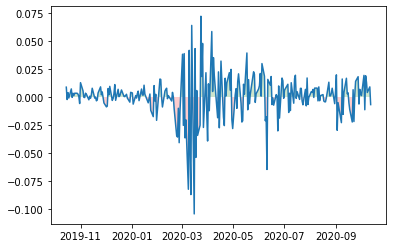

In [6]:
mean = downloader.returns.copy().diff().T.mean().T

plt.plot(mean)
plt.fill_between(mean.index, 0, mean, where=mean > 0, facecolor='green', interpolate=True, alpha=0.2)
plt.fill_between(mean.index, 0, mean, where=mean < 0, facecolor='red', interpolate=True, alpha=0.2)
plt.show()

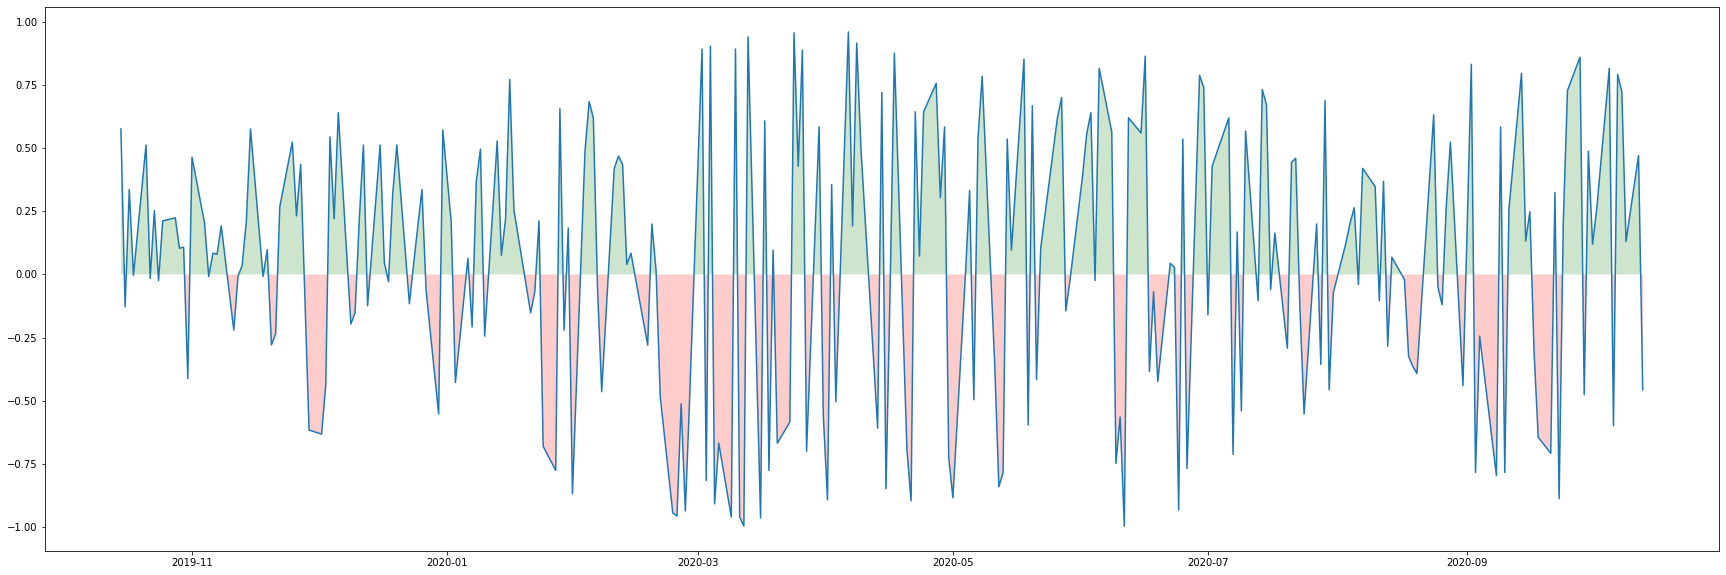

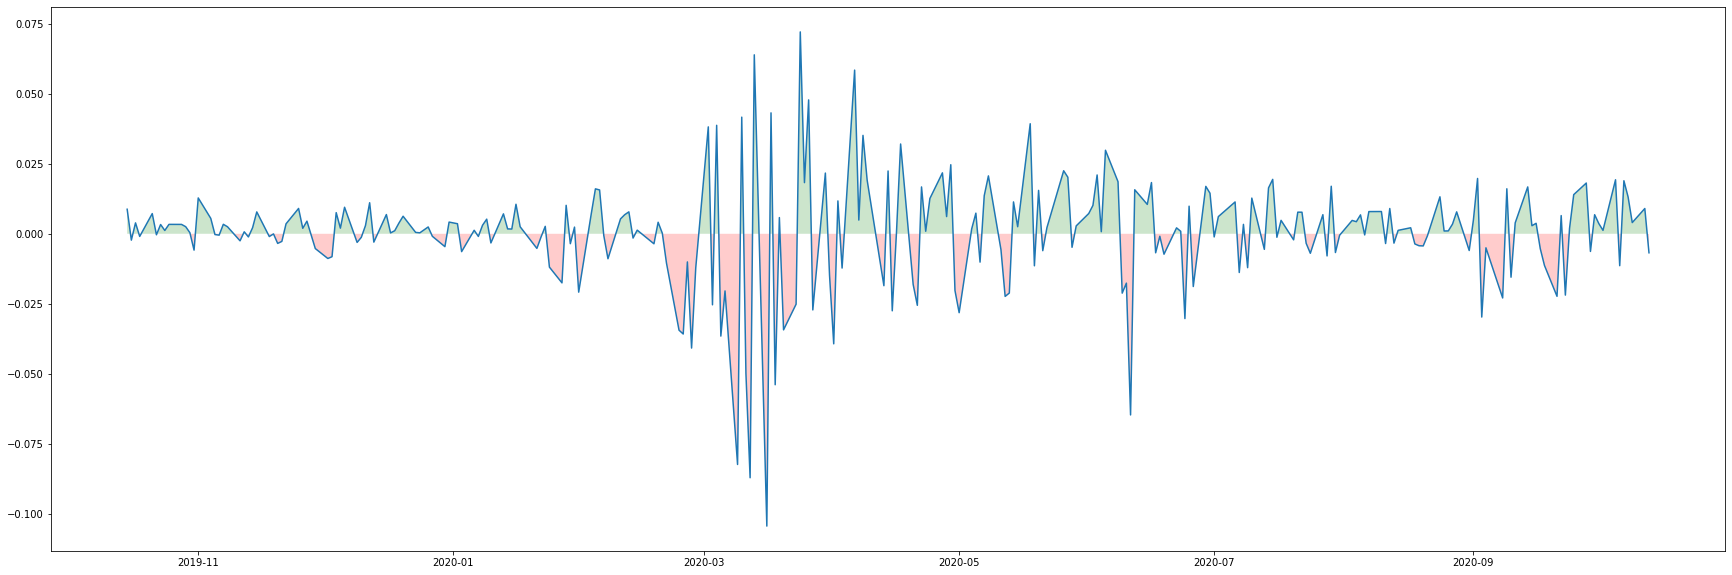

In [7]:
mean = downloader.returns.copy().diff().T.mean().T
diff = downloader.returns.copy().diff()
diffT = diff.T
diff['count'] = diffT.count()
diff['countUp'] = diffT[diffT>0].count()
diff['countDown'] = diffT[diffT<0].count()
diff['mean'] = mean
diff['signal'] = ((diff['countUp']-(diff['count']/2))/(diff['count']/2))#*abs(diff['mean'])

signal = diff['signal']

plt.figure(figsize=(30,10))
plt.plot(signal)
plt.fill_between(signal.index, 0, signal, where=signal > 0, facecolor='green', interpolate=True, alpha=0.2)
plt.fill_between(signal.index, 0, signal, where=signal < 0, facecolor='red', interpolate=True, alpha=0.2)
plt.show()

mean = downloader.returns.copy().diff().T.mean().T
plt.figure(figsize=(30,10))
plt.plot(mean)
plt.fill_between(mean.index, 0, mean, where=mean > 0, facecolor='green', interpolate=True, alpha=0.2)
plt.fill_between(mean.index, 0, mean, where=mean < 0, facecolor='red', interpolate=True, alpha=0.2)
plt.show()

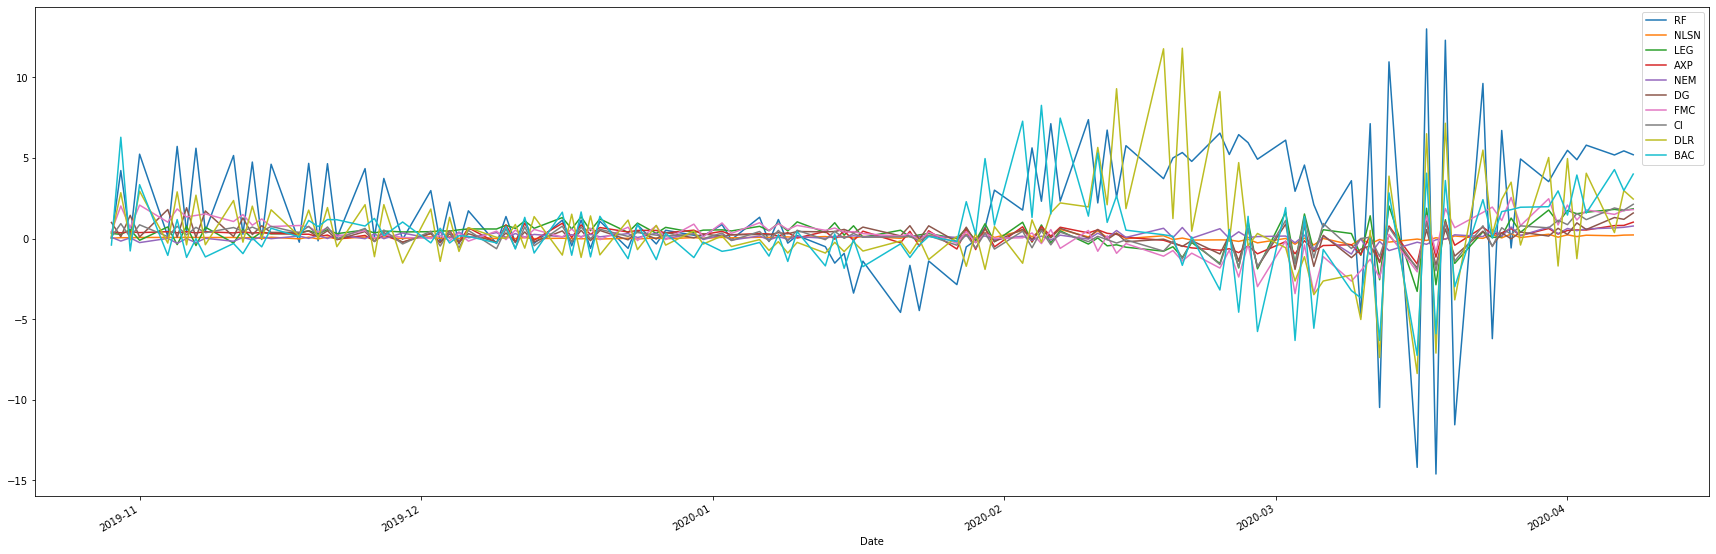

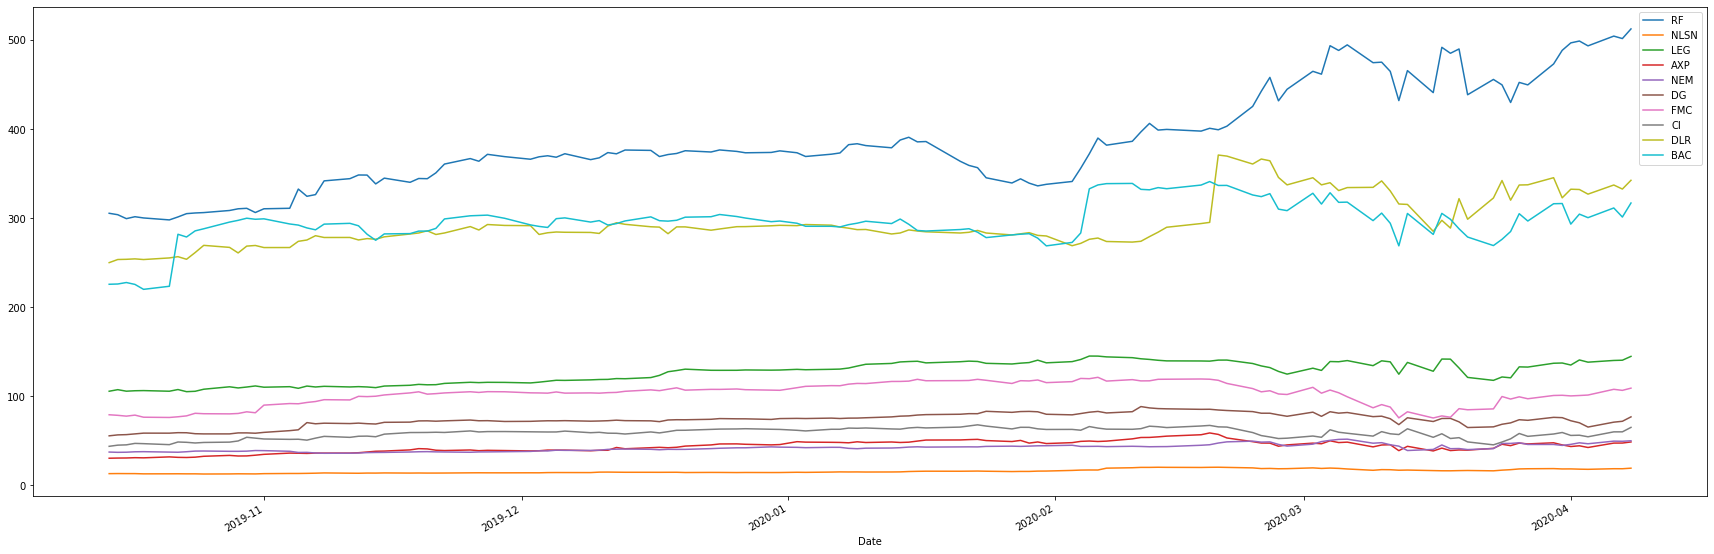

In [8]:
prices = downloader.prices.iloc[:-130]
prices = prices.T.loc[picks.index].T

noiseless = picker.noiseless(prices, steps=10).diff()
noiseless = picker.noiseless(noiseless, steps=10)
noiseless.plot(figsize=(30,10))
plt.show()
prices.plot(figsize=(30,10))
plt.show()

### Order

Returns:
- returns
- prices
- selected

How to use:
```
order = Order(prices=downloader.prices, picks=picker.selected)
order.get(budget=5000)
```

In [9]:
class Order:
  def __init__(self, prices, picks):
    self.picks = picks
    self.prices = prices[list(picks.index)]
  
  def get(self, budget=5000):
    weights = {}
    pickWeights = self.picks[['sharpe']].copy()
    pickWeights['weight']      = pickWeights[['sharpe']]/pickWeights[['sharpe']].sum()
    for symbol in list(self.picks.index):
      weights[symbol] = pickWeights.at[symbol, 'weight']#1/len(list(self.picks.index))
    weights = self.toDataFrame(weights)
    orders, leftovers   = self.getOrder(weights, budget)
    #orders.plot.pie(y='budget_weight', figsize=(5, 5))
    orders = pd.concat([orders, self.picks], axis=1)
    self.orders = orders
    self.leftovers = leftovers
    return orders, leftovers

  # Convert a weight dict to a dataframe with latest prices
  def toDataFrame(self, portfolio):
    dfo = {'symbol': [], 'price': [], 'weight': []}
    dfo['symbol'] = list(portfolio.keys())
    last_index  = self.prices.index[-1]
    last_prices = self.prices.loc[last_index]
    dfo['price'] = list(last_prices)
    dfo['weight'] = list(portfolio.values())
    prices = pd.DataFrame.from_dict(dfo)
    prices = prices.set_index('symbol')
    return prices
  
  def filterAffordable(self, affordable, leftover):
    #print('+++++++++++++++')
    #print("filterAffordable("+str(leftover)+")")
    data = affordable.copy();
    # Rebuild the weights
    data['weight']      = data[['weight']]/data[['weight']].sum()
    data['order_size']  = data['weight']*leftover
    data.sort_values(by=['weight'], inplace=True)
    #print(data)
    #print('+++++++++++++++')
    left = data[data['order_size'] >= data['price']]
    if len(left) == 0:
      # Drop the lowest weight
      ndata = data.iloc[1:]
      ndata = ndata.drop(['order_size'], axis=1)

      if len(ndata) == 0:
        return data
      else:
        return self.filterAffordable(ndata, leftover)
    return data

  def getOrder(self, weights, balance=10000, filter=False):
    wdata = weights.copy()
    # Sort by weight asc
    wdata.sort_values(by=['weight'], inplace=True)

    # Calculate the budget & size
    wdata['budget'] = (balance*wdata[['weight']])
    wdata['order_size']  = wdata['budget']/wdata['price']
    wdata['order_size']  = wdata[['order_size']].apply(np.floor)
    wdata['order_value'] = wdata['order_size']*wdata['price']

    # Maximize the invested value
    leftover            = balance - wdata[['order_value']].sum()[0]
    minPrice            = wdata[['price']].min()[0]

    # Filter out what we can't afford
    affordable  = wdata[wdata['price'] <= leftover]
    affordable = affordable.drop(['budget','order_size','order_value'], axis=1)
    # Rebuild the weights
    #affordable['weight'] = affordable[['weight']]/affordable[['weight']].sum()
    #affordable['order_size']  = affordable['weight']*leftover

    affordable = self.filterAffordable(affordable, leftover)

    if len(affordable) > 0:
     
      new_df, leftover  = self.getOrder(affordable, leftover)
      new_df = new_df.dropna()
      # Merge with the new data
      for symbol, row in new_df.iterrows():
        wdata.at[symbol, 'order_size'] = wdata.at[symbol, 'order_size'] + row['order_size']
      
      wdata['order_value'] = wdata['order_size']*wdata['price']
      leftover            = balance - wdata[['order_value']].sum()[0]
      minPrice            = wdata[['price']].min()[0]
    wdata = wdata.dropna()

    if filter == True:
      wdata = wdata[wdata['order_size'] > 0]
    
    wdata['budget_weight'] = wdata[['order_value']]/wdata[['order_value']].sum()
    return wdata, leftover

order = Order(prices=downloader.prices, picks=picker.selected)
order.get(budget=5000)

(           price    weight      budget  order_size  order_value  budget_weight         min         max  first_price  last_price    return        3d        7d       20d       50d      100d    sharpe     trend
 BAC   291.799988  0.075866  379.331123         1.0   291.799988       0.058384  220.059998  341.040009   225.759995  316.950012  0.403925  0.024628  0.002525  0.212925  0.152507  0.185152  1.077502  0.011515
 DLR   404.559998  0.080505  402.526847         0.0     0.000000       0.000000  250.044968  370.792206   250.044968  342.451263  0.369559  0.021151  0.078709  0.106432  0.235128  0.264642  1.143390  0.005729
 CI     65.709999  0.081169  405.843076         7.0   459.969994       0.092032   43.900002   68.019997    43.900002   65.150002  0.484055  0.114579  0.130752  0.182688 -0.001139  0.239180  1.152810  0.031594
 FMC   129.755005  0.083978  419.888829         3.0   389.265015       0.077885   75.699997  121.330002    79.309998  109.180000  0.376623  0.016391  0.100996  0.42

### Portfolio

Returns:
- Unknown

How to use:
```
portfolio = Portfolio()
portfolio.buy(orders=order.orders)
```

In [24]:

class Portfolio:
  def __init__(self, cash=5000, sl=-0.1, tp=0.25, cutoff=0.2):
    self.cash     = cash
    self.sl       = sl
    self.tp       = tp
    self.cutoff   = cutoff
    self.holdings = pd.DataFrame(columns=['symbol','purchase_date','sell_date','status','purchase_price','current_price','profits','profits_pct'])

  # Refresh the positions with fresh price data
  # Delete the positions that aren't performing well
  def refresh(self, prices, date):
    # Check the no-lag market trend
    zt    = TradingZones(prices=prices)
    zones = zt.get()
    marketDrop = zones.iloc[-1]['signal'] == "DOWN"
    #marketDrop = zones.iloc[-1]['zone'] < 0 and zones.iloc[-2]['zone'] < 0

    opened = self.holdings[self.holdings['status']=='open']
    symbols = opened['symbol'].unique()
    for symbol in symbols:
      subsetIds = opened[opened['symbol']==symbol].index
      # Update the holdings
      self.holdings.loc[subsetIds, 'current_price'] = prices[symbol].iloc[-1]
      self.holdings.loc[subsetIds, 'profits']       = self.holdings.loc[subsetIds, 'current_price'] - self.holdings.loc[subsetIds, 'purchase_price']
      self.holdings.loc[subsetIds, 'profits_pct']   = (self.holdings.loc[subsetIds, 'current_price'] - self.holdings.loc[subsetIds, 'purchase_price'])/self.holdings.loc[subsetIds, 'purchase_price']
    
    # Get the ones that are not performing well
    opened = self.holdings[self.holdings['status']=='open']
    poor_perfs  = opened[opened['profits_pct']<=self.sl]
    if len(poor_perfs) > 0:
      sell_list   = poor_perfs['symbol'].unique()
      sell_orders = self.getSellAllOrders(symbols=sell_list)
      #print('')
      #print('-- Poor Performers --')
      #print(poor_perfs)
      self.sell(sell_orders, prices, date)
    
    # Get the ones that are are performing very well
    opened = self.holdings[self.holdings['status']=='open']
    good_perfs  = opened[opened['profits_pct']>=self.tp]
    if len(good_perfs) > 0:
      sell_list   = good_perfs['symbol'].unique()
      sell_orders = self.getSellAllOrders(symbols=sell_list)
      #print('')
      #print('-- Good Performers --')
      #print(good_perfs)
      self.sell(sell_orders, prices, date)
    
    # Cut off all positions if we reach a cutoff or if the market turns globally
    summary   = self.summary()
    drawdown  = summary['portfolio_value']-summary['invested']
    cutoff    = summary['invested']*self.cutoff
    if drawdown < -cutoff or marketDrop == True:
      if drawdown < -cutoff:
        print("Cut-Off! drawdown:", drawdown)
      #if marketDrop == True:
        #print("Market drop! Value:", summary['total_value'])
      negative_perfs  = opened
      if len(negative_perfs) > 0:
        sell_list   = negative_perfs['symbol'].unique()
        sell_orders = self.getSellAllOrders(symbols=sell_list)
        #print('')
        #print('-- Negative Performers --')
        #print(negative_perfs)
        self.sell(sell_orders, prices, date)
    return marketDrop

  # Update the holdings based on purchase orders
  def update(self, orders, prices, date):
    if len(orders)>0:
      #buy_orders, sell_orders = self.computeOrders(orders)
      buy_orders = self.getBuyOrders(orders)
      #print('')
      #print('-- Buy orders --')
      #print(buy_orders)
      self.buy(buy_orders, prices, date)
  
  # Sell All
  def sellAll(self, prices, date, symbols=None):
    sell_orders = self.getSellAllOrders(symbols=symbols)
    return self.sell(sell_orders, prices, date)
  
  def buy(self, buy_orders, prices, date):
    #print("Buy Value", buy_orders.sum()['total_value'])
    for symbol, row in buy_orders.iterrows():
      for i in range(0, int(row['count'])):
        # Pay for the order
        if self.cash >= prices[symbol].iloc[-1]:
          self.cash = self.cash - prices[symbol].iloc[-1]
          #print("Buying 1x "+symbol+" for $"+str(prices[symbol].iloc[-1])+" | Cash: $"+str(self.cash))
          self.holdings = self.holdings.append({
              "symbol":         symbol,
              "purchase_date":  date,
              "sell_date":      None,
              "purchase_price": prices[symbol].iloc[-1],
              "current_price":  prices[symbol].iloc[-1],
              "status":         'open'
          }, ignore_index=True)
        else:
          print("# Not enough cash to purchase "+symbol+" at ", prices[symbol].iloc[-1])
  
  def sell(self, sell_orders, prices, date):
    for symbol, row in sell_orders.iterrows():
      subsetIds = self.holdings[self.holdings['symbol']==symbol]
      subsetIds = subsetIds[subsetIds['status']=='open']
      subsetIds = subsetIds.head(int(row['count'])).index
      # Update the holdings
      self.holdings.loc[subsetIds, 'current_price'] = prices[symbol].iloc[-1]
      self.holdings.loc[subsetIds, 'status']        = 'closed'
      self.holdings.loc[subsetIds, 'profits']       = self.holdings.loc[subsetIds, 'current_price'] - self.holdings.loc[subsetIds, 'purchase_price']
      self.holdings.loc[subsetIds, 'profits_pct']   = (self.holdings.loc[subsetIds, 'current_price'] - self.holdings.loc[subsetIds, 'purchase_price'])/self.holdings.loc[subsetIds, 'purchase_price']
      self.holdings.loc[subsetIds, 'sell_date']     = date
      # Calculate the profits & how much we're getting back out
      subset    = self.holdings[self.holdings.index.isin(subsetIds)]
      self.cash = self.cash + subset['current_price'].sum()
      #print("Selling "+str(len(subsetIds))+"x "+symbol+" for $"+str(subset['current_price'].sum())+" with a $"+str(subset['profits'].sum())+" gain | Cash: $"+str(self.cash))
  
  def computeOrders(self, orders):
    opened = self.holdings[self.holdings['status']=='open'].groupby(['symbol'])
    holding_stats = opened.sum()
    holding_stats['count'] = opened.count()['purchase_date']
    
    # Sell the positions that aren't part of the new portfolio
    sell_list = [i for i in list(holding_stats.index) if i not in list(orders.index)]
    sell_orders = pd.DataFrame()
    if len(sell_list) > 0:
      # Sell those positions entirely
      sell_orders = holding_stats[holding_stats.index.isin(sell_list)].copy()
      sell_orders = sell_orders.drop(columns=['purchase_price','profits'])
      sell_orders['current_price'] = sell_orders['current_price']/sell_orders['count']
      sell_orders['total_value'] = sell_orders['current_price']*sell_orders['count']
    # Find the positions to update
    update_list = [i for i in list(holding_stats.index) if i in list(orders.index)]
    update_order = orders[orders.index.isin(update_list)]
    diff = update_order[['order_size']].copy()
    diff['prev_order_size'] = holding_stats['count']
    diff['diff'] = diff['order_size']-diff['prev_order_size']
    diff['current_price'] = orders[orders.index.isin(diff.index)]['last_price']
    #print('-- diff --')
    #print(diff)
    buy_orders = pd.DataFrame()
    buy_orders['count'] = orders['order_size']
    buy_orders['current_price'] = orders['last_price']
    buy_orders['total_value'] = buy_orders['current_price']*buy_orders['count']
    for symbol, row in diff.iterrows():
      if row['diff'] > 0:
        # Buy
        if symbol in list(buy_orders.index):
          buy_orders.loc[symbol, 'count'] = buy_orders.loc[symbol, 'count'] + row['diff']
        else:
          buy_orders.loc[symbol, 'count'] = row['diff']
      elif row['diff'] < 0:
        # Sell
        if symbol in list(sell_orders.index):
          sell_orders.loc[symbol, 'count'] = sell_orders.loc[symbol, 'count'] + abs(row['diff'])
        else:
          sell_orders.loc[symbol, 'count'] = abs(row['diff'])
        sell_orders.loc[symbol, 'current_price']  = row['current_price']
        sell_orders.loc[symbol, 'total_value']    = row['current_price']*abs(row['diff'])
        buy_orders.loc[symbol, 'count'] = 0
    buy_orders = buy_orders[buy_orders['count'] > 0]
    return buy_orders, sell_orders
  
  def getSellAllOrders(self, symbols=None):
    opened = self.holdings[self.holdings['status']=='open']
    if symbols is not None:
      opened = opened[opened['symbol'].isin(symbols)]
    opened = opened.groupby(['symbol'])
    holding_stats = opened.sum()
    if len(holding_stats) > 0:
      holding_stats['count'] = opened.count()['purchase_date']
      sell_orders = holding_stats.copy()
      sell_orders = sell_orders.drop(columns=['purchase_price','profits'])
      sell_orders['current_price'] = sell_orders['current_price']/sell_orders['count']
      sell_orders['total_value'] = sell_orders['current_price']*sell_orders['count']
      return sell_orders
    return pd.DataFrame()
  
  def getBuyOrders(self, orders):
    buy_orders = pd.DataFrame()
    buy_orders['count'] = orders['order_size']
    buy_orders['current_price'] = orders['last_price']
    buy_orders['total_value'] = buy_orders['current_price']*buy_orders['count']
    buy_orders = buy_orders[buy_orders['count']>0]
    return buy_orders

  def holdingStats(self):
    opened = self.holdings[self.holdings['status']=='open'].copy()
    closed = self.holdings[self.holdings['status']=='closed'].copy()
    openGroup = opened.groupby(['symbol'])
    stats_open = openGroup.sum()
    stats_open['count'] = openGroup.count()['purchase_date']

    closedGroup = closed.groupby(['symbol'])
    stats_closed = closedGroup.sum()
    stats_closed['count'] = closedGroup.count()['purchase_date']
    print("-- Opened --")
    print(stats_open)
    print("-- Closed --")
    print(stats_closed)
  
  def getOrderValue(self, order):
    if len(order):
      data = order.copy();
      data['val'] = data['count']*data['current_price']
      print(data)
      sum = data.sum()['val']
      print("Sum: ", sum)
    else:
      print("None")
  
  def summary(self):
    return {
        "invested":       self.holdings[self.holdings['status']=='open'][['purchase_price']].sum()[0],
        "portfolio_value":self.holdings[self.holdings['status']=='open'][['current_price']].sum()[0],
        "Positions":      len(self.holdings),
        "closed":         len(self.holdings[self.holdings['status']=='closed']),
        "opened":         len(self.holdings[self.holdings['status']=='open']),
        "cash":           self.cash,
        "total_value":    self.holdings[self.holdings['status']=='open'][['current_price']].sum()[0]+self.cash
    }


### Sim

Returns:
- Unknown

How to use:
```
sim = Sim(period='2y', timestep=5, budget=5000)
sim.tick()
```

In [11]:
class Sim:
  def __init__(self, period='2y', timedelay=100, window=100, timestep=5, budget=5000, stockPicks=10, sl=-0.1, tp=0.25, cutoff=0.2):
    self.period     = period
    self.timedelay  = timedelay
    self.timestep   = timestep
    self.budget     = budget
    self.stockPicks = stockPicks
    self.sl         = sl
    self.tp         = tp
    self.cutoff     = cutoff
    self.portfolio  = Portfolio(cash=budget, sl=self.sl, tp=self.tp, cutoff=self.cutoff)
    self.downloader = Downloader()
    self.downloader.download(period=self.period)
    self.current_index = timedelay
  
  def progress(self, value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 50%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))
  
  def run(self):
    out = display(self.progress(0, 100), display_id=True)
    steps = (len(self.downloader.prices)-self.timedelay)
    stepN = 0
    stats = pd.DataFrame()
    while self.current_index+self.timestep < len(self.downloader.prices):
      output = self.tick()
      output['date'] = self.downloader.prices.index[self.current_index]
      stats = stats.append(output, ignore_index=True)
      #stats.at[self.downloader.prices.index[self.current_index]] = self.tick()
      stepN = stepN + 1
      pct = math.ceil((stepN/steps)*100)
      out.update(self.progress(pct, 100))
    self.portfolio.sellAll(prices=self.downloader.prices[:self.current_index], date=self.downloader.prices.index[self.current_index])
    stats = stats.set_index('date')
    return stats
  
  def tick(self):
    #print('\n\n----------- tick -----------')
    # Get the latest prices
    prices = self.downloader.prices[:self.current_index]
    # Refresh the portfolio with the latest prices, sell what needs to be sold
    marketDrop = self.portfolio.refresh(prices=prices, date=self.downloader.prices.index[self.current_index])
    # Get the portfolio summary
    portfolio_summary = self.portfolio.summary()
    if marketDrop==False:
      # Pick the stocks
      picker = Picker(prices=prices)
      picker.pick(count=self.stockPicks)
      # Get the order size
      order   = Order(prices=prices, picks=picker.selected)
      order.get(budget=portfolio_summary['cash'])
      # Update our portfolio
      self.portfolio.update(orders=order.orders, prices=prices, date=self.downloader.prices.index[self.current_index])
    else:
      # Update our portfolio
      self.portfolio.update(orders=pd.DataFrame(), prices=prices, date=self.downloader.prices.index[self.current_index])
    # Update the index
    if self.current_index + self.timestep < len(self.downloader.prices):
      self.current_index = self.current_index + self.timestep
    portfolio_summary = self.portfolio.summary()
    return portfolio_summary


## Analysis

In [12]:
class Analysis:
  def __init__(self, stats, positions):
    self.stats      = stats
    self.positions  = positions
  
  def chart(self):
    #self.stats[['invested','portfolio_value','total_value']].plot(figsize=(30,5))
    self.stats['profits'] = self.stats['total_value']-self.stats.iloc[0]['total_value']
    self.stats['drawdown'] = self.stats['total_value']-self.stats['invested']
    fig, axs = plt.subplots(3, figsize=(30,10))
    fig.suptitle('Analysis')
    for col in ['invested','portfolio_value','total_value']:
      axs[0].plot(self.stats[col], '--', label=col)
      if col == 'total_value':
        axs[0].fill_between(self.stats.index, self.stats.iloc[0]['total_value'], self.stats['total_value'], where=self.stats['total_value'] > self.stats.iloc[0]['total_value'], facecolor='green', interpolate=True, alpha=0.2)
        axs[0].fill_between(self.stats.index, self.stats.iloc[0]['total_value'], self.stats['total_value'], where=self.stats['total_value'] < self.stats.iloc[0]['total_value'], facecolor='red', interpolate=True, alpha=0.2)
    
    axs[1].fill_between(self.stats.index, 0, self.stats['profits'], where=self.stats['profits'] > 0, facecolor='green', interpolate=True, alpha=0.2)
    axs[1].fill_between(self.stats.index, 0, self.stats['profits'], where=self.stats['profits'] < 0, facecolor='red', interpolate=True, alpha=0.2)
    axs[1].plot(self.stats['profits'], label='Profits')
    group = self.positions.copy()
    group = group.set_index('sell_date')
    group = group.groupby(group.index)['profits'].sum()
    profits = pd.DataFrame(index=stats.index, data=np.zeros(len(stats.index)))
    profits['profits'] = group
    axs[1].plot(profits['profits'][profits['profits']>0], 'g^')
    axs[1].plot(profits['profits'][profits['profits']<0], 'rv')

    axs[2].plot(self.stats['drawdown'], label='Drawdown')
    axs[2].fill_between(self.stats.index, 0, self.stats['drawdown'], facecolor='red', interpolate=True, alpha=0.2)

    axs[0].legend(shadow=True, fancybox=True)
    axs[1].legend(shadow=True, fancybox=True)
    plt.show()
  
  def chartPies(self, figsize=(5,5)):
    holdings = self.positions.copy()
    holdings = holdings.groupby('symbol')

    holdings.count().plot.pie(y='purchase_date', figsize=figsize, title="By Shares", legend=False)
    plt.show()

    sums = holdings.sum()

    sums.plot.pie(y='purchase_price', figsize=figsize, title="By Investment", legend=False)
    plt.show()

    in_profit = sums[sums['profits']>0]
    in_profit.plot.pie(y='profits', figsize=figsize, title="Biggest Winners (value)", legend=False)
    plt.show()

    in_loss = sums[sums['profits']<0].copy()
    in_loss['profits'] = abs(in_loss['profits'])
    in_loss.plot.pie(y='profits', figsize=figsize, title="Biggest Losers (value)", legend=False)
    plt.show()

    in_profit.plot.pie(y='profits_pct', figsize=figsize, title="Biggest Winners (Gains)", legend=False)
    plt.show()

    in_loss['profits_pct'] = abs(in_loss['profits_pct'])
    in_loss.plot.pie(y='profits_pct', figsize=figsize, title="Biggest Losers (Loss)", legend=False)
    plt.show()
  
  def sharpe(self):
    total_value = self.stats[['total_value']]
    returns  = (total_value[:]-total_value[:].loc[list(total_value.index)[0]])/total_value[:].loc[list(total_value.index)[0]]
    return ((252**0.5) * returns.diff().mean() / returns.diff().std())['total_value']
  
  def positionStats(self):
    positives = self.positions[self.positions['profits']>0]
    positives = dict(positives.describe()['profits'])
    negatives = self.positions[self.positions['profits']<0]
    negatives = dict(negatives.describe()['profits'])
    _obj = {
        "startValue": self.stats.iloc[0]['total_value'],
        "endValue":   self.stats.iloc[-1]['total_value'],
        "gains":      (self.stats.iloc[-1]['total_value']-self.stats.iloc[0]['total_value'])/self.stats.iloc[0]['total_value']*100,
        "sharpe":     self.sharpe(),
        "winRate":    positives['count']/(positives['count']+negatives['count'])*100,
        "profitRatio":positives['max']/abs(negatives['min']),
        "maxValue":   self.stats['total_value'].max(),
        "minValue":   self.stats['total_value'].min(),
        "maxGain":    (self.stats['total_value'].max()-self.stats.iloc[0]['total_value'])/self.stats.iloc[0]['total_value']*100,
        "minGain":   (self.stats['total_value'].min()-self.stats.iloc[0]['total_value'])/self.stats.iloc[0]['total_value']*100,
        "dropFromHigh":   (self.stats['total_value'].max()-self.stats.iloc[-1]['total_value'])/self.stats['total_value'].max(),
        "riseFromLow":   (self.stats.iloc[-1]['total_value']-self.stats['total_value'].min())/self.stats['total_value'].min(),
        "profits":      self.stats.iloc[-1]['total_value']-self.stats.iloc[0]['total_value']
    }
    output = pd.DataFrame(columns=['startValue','endValue','profits','gains','minGain','maxGain','minValue','maxValue','dropFromHigh','riseFromLow','profitRatio','winRate','sharpe'])
    output = output.append(_obj, ignore_index=True)
    stats = {
        "positives":  positives,
        "negatives":  negatives,
        "value":      dict(self.stats.describe()['total_value']),
        "profits":    dict(self.positions.describe()['profits_pct']),
    }
    return output, stats






## Testing

In [13]:
test = False
if test == True:
  # Sharpe 1.27 / 49% gains
  sim = Sim(period='1y', timedelay=100, window=100, timestep=1, budget=5000, sl=-0.1, tp=0.1, stockPicks=10, cutoff=0.1)

  #sim.tick()
  stats = sim.run()

  analysis = Analysis(stats=stats, positions=sim.portfolio.holdings)
  analysis.chart()
  #analysis.chartPies()
  output, advanced_stats = analysis.positionStats()
  #print(json.dumps(advanced_stats, indent=4, sort_keys=True))
  output

## Todo

- Noiseless on data
- Detect trend on data

Download:  None None
Using cached data


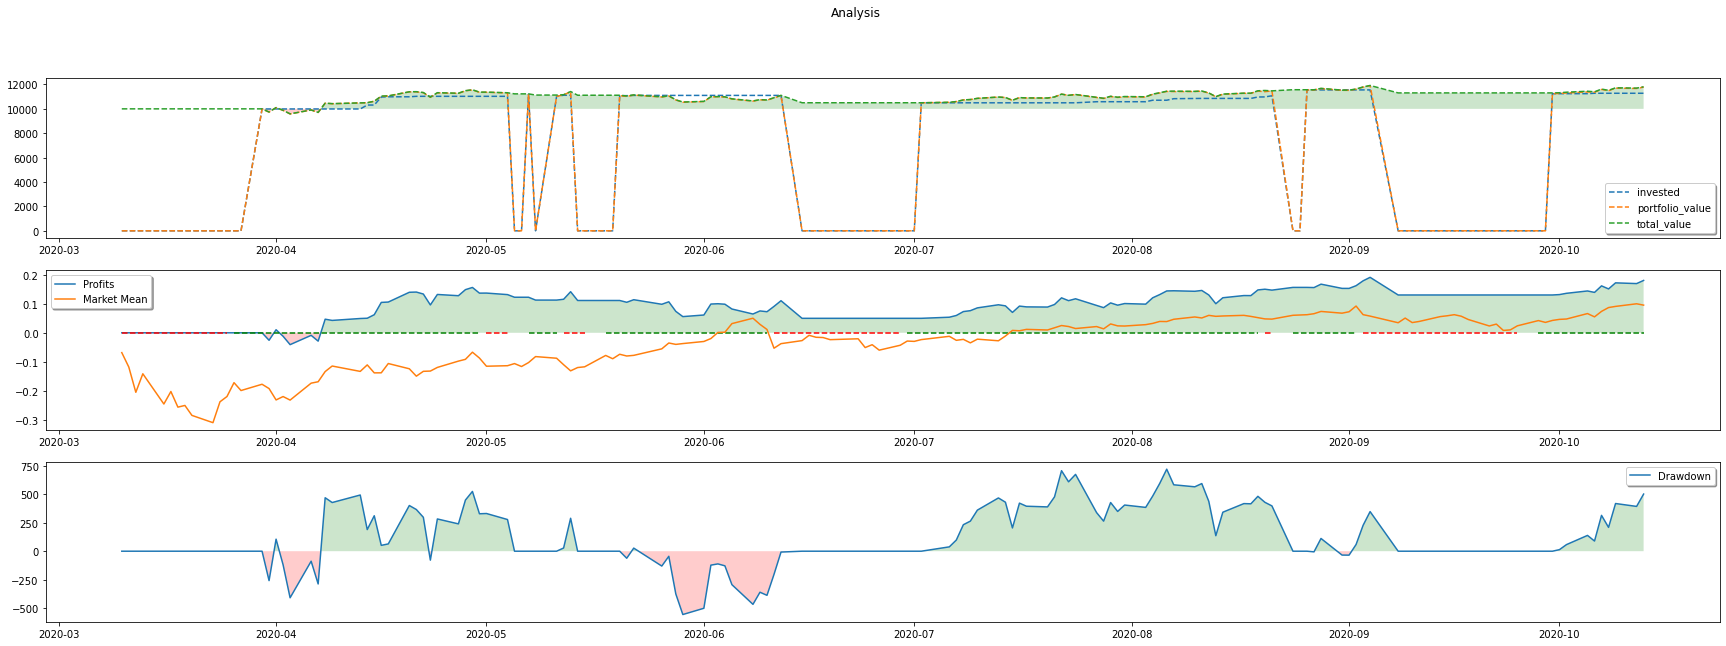

,startValue,endValue,profits,gains,minGain,maxGain,minValue,maxValue,dropFromHigh,riseFromLow,profitRatio,winRate,sharpe
0,10000.0,11809.452778,1809.452778,18.094528,-4.095731,19.174129,9590.426933,11917.412899,0.009059,0.231379,1.0549,53.649289,1.173914


In [45]:
class Analysis:
  def __init__(self, stats, positions, prices):
    self.stats      = stats
    self.positions  = positions
    self.prices     = prices
  
  def chart(self):
    zt = TradingZones(prices=self.prices)
    zones = zt.get()
    self.stats = pd.concat([self.stats, zones[zones.index.isin(self.stats.index)]], axis=1)
    self.stats[['sign_up','sig_down']] = None
    self.stats.at[self.stats[self.stats['signal']=='UP'].index, 'sig_up'] = 0
    self.stats.at[self.stats[self.stats['signal']=='DOWN'].index, 'sig_down'] = 0

    #self.stats[['invested','portfolio_value','total_value']].plot(figsize=(30,5))
    self.stats['profits'] = (self.stats['total_value']-self.stats.iloc[0]['total_value'])/self.stats.iloc[0]['total_value']
    self.stats['drawdown'] = self.stats['portfolio_value']-self.stats['invested']
    fig, axs = plt.subplots(3, figsize=(30,10))
    fig.suptitle('Analysis')
    for col in ['invested','portfolio_value','total_value']:
      axs[0].plot(self.stats[col], '--', label=col)
      if col == 'total_value':
        axs[0].fill_between(self.stats.index, self.stats.iloc[0]['total_value'], self.stats['total_value'], where=self.stats['total_value'] > self.stats.iloc[0]['total_value'], facecolor='green', interpolate=True, alpha=0.2)
        axs[0].fill_between(self.stats.index, self.stats.iloc[0]['total_value'], self.stats['total_value'], where=self.stats['total_value'] < self.stats.iloc[0]['total_value'], facecolor='red', interpolate=True, alpha=0.2)
    
    axs[1].fill_between(self.stats.index, 0, self.stats['profits'], where=self.stats['profits'] > 0, facecolor='green', interpolate=True, alpha=0.2)
    axs[1].fill_between(self.stats.index, 0, self.stats['profits'], where=self.stats['profits'] < 0, facecolor='red', interpolate=True, alpha=0.2)
    axs[1].plot(self.stats['profits'], label='Profits')
    axs[1].plot(self.stats['sig_up'], 'g--')
    axs[1].plot(self.stats['sig_down'], 'r--')
    group = self.positions.copy()
    group = group.set_index('sell_date')
    group = group.groupby(group.index)['profits'].sum()
    profits = pd.DataFrame(index=stats.index, data=np.zeros(len(stats.index)))
    profits['profits'] = group
    #axs[1].plot(profits['profits'][profits['profits']>0], 'g^')
    #axs[1].plot(profits['profits'][profits['profits']<0], 'rv')

    axs[2].plot(self.stats['drawdown'], label='Drawdown')
    axs[2].fill_between(self.stats.index, 0, self.stats['drawdown'], where=self.stats['drawdown'] > 0, facecolor='green', interpolate=True, alpha=0.2)
    axs[2].fill_between(self.stats.index, 0, self.stats['drawdown'], where=self.stats['drawdown'] < 0, facecolor='red', interpolate=True, alpha=0.2)

    axs[1].plot(self.stats['mean'], label='Market Mean')

    axs[0].legend(shadow=True, fancybox=True)
    axs[1].legend(shadow=True, fancybox=True)
    axs[2].legend(shadow=True, fancybox=True)
    plt.show()
    return self.stats
  
  def chartPies(self, figsize=(5,5)):
    holdings = self.positions.copy()
    holdings = holdings.groupby('symbol')

    holdings.count().plot.pie(y='purchase_date', figsize=figsize, title="By Shares", legend=False)
    plt.show()

    sums = holdings.sum()

    sums.plot.pie(y='purchase_price', figsize=figsize, title="By Investment", legend=False)
    plt.show()

    in_profit = sums[sums['profits']>0]
    in_profit.plot.pie(y='profits', figsize=figsize, title="Biggest Winners (value)", legend=False)
    plt.show()

    in_loss = sums[sums['profits']<0].copy()
    in_loss['profits'] = abs(in_loss['profits'])
    in_loss.plot.pie(y='profits', figsize=figsize, title="Biggest Losers (value)", legend=False)
    plt.show()

    in_profit.plot.pie(y='profits_pct', figsize=figsize, title="Biggest Winners (Gains)", legend=False)
    plt.show()

    in_loss['profits_pct'] = abs(in_loss['profits_pct'])
    in_loss.plot.pie(y='profits_pct', figsize=figsize, title="Biggest Losers (Loss)", legend=False)
    plt.show()
  
  def sharpe(self):
    total_value = self.stats[['total_value']]
    returns  = (total_value[:]-total_value[:].loc[list(total_value.index)[0]])/total_value[:].loc[list(total_value.index)[0]]
    return ((252**0.5) * returns.diff().mean() / returns.diff().std())['total_value']
  
  def positionStats(self):
    positives = self.positions[self.positions['profits']>0]
    positives = dict(positives.describe()['profits'])
    negatives = self.positions[self.positions['profits']<0]
    negatives = dict(negatives.describe()['profits'])
    _obj = {
        "startValue": self.stats.iloc[0]['total_value'],
        "endValue":   self.stats.iloc[-1]['total_value'],
        "gains":      (self.stats.iloc[-1]['total_value']-self.stats.iloc[0]['total_value'])/self.stats.iloc[0]['total_value']*100,
        "sharpe":     self.sharpe(),
        "winRate":    positives['count']/(positives['count']+negatives['count'])*100,
        "profitRatio":positives['max']/abs(negatives['min']),
        "maxValue":   self.stats['total_value'].max(),
        "minValue":   self.stats['total_value'].min(),
        "maxGain":    (self.stats['total_value'].max()-self.stats.iloc[0]['total_value'])/self.stats.iloc[0]['total_value']*100,
        "minGain":   (self.stats['total_value'].min()-self.stats.iloc[0]['total_value'])/self.stats.iloc[0]['total_value']*100,
        "dropFromHigh":   (self.stats['total_value'].max()-self.stats.iloc[-1]['total_value'])/self.stats['total_value'].max(),
        "riseFromLow":   (self.stats.iloc[-1]['total_value']-self.stats['total_value'].min())/self.stats['total_value'].min(),
        "profits":      self.stats.iloc[-1]['total_value']-self.stats.iloc[0]['total_value']
    }
    output = pd.DataFrame(columns=['startValue','endValue','profits','gains','minGain','maxGain','minValue','maxValue','dropFromHigh','riseFromLow','profitRatio','winRate','sharpe'])
    output = output.append(_obj, ignore_index=True)
    stats = {
        "positives":  positives,
        "negatives":  negatives,
        "value":      dict(self.stats.describe()['total_value']),
        "profits":    dict(self.positions.describe()['profits_pct']),
    }
    return output, stats

#sim    = Sim(period='1y', timedelay=100, window=100, timestep=1, budget=10000, sl=-0.20, tp=0.15, stockPicks=15, cutoff=0.1)
#stats  = sim.run()


analysis = Analysis(stats=stats, positions=sim.portfolio.holdings, prices=sim.downloader.prices)
blah = analysis.chart()
#analysis.chartPies()
output, advanced_stats = analysis.positionStats()
#print(json.dumps(advanced_stats, indent=4, sort_keys=True))
output

In [52]:
g = sim.portfolio.holdings.copy().groupby('sell_date').sum()
g['profits_pct'] = (g['current_price']-g['purchase_price'])/g['purchase_price']*100
g

,purchase_price,current_price,profits,profits_pct
sell_date,,,,
2020-04-13,1676.179218,1989.681854,313.502636,18.703408
2020-04-15,4270.320049,4955.640045,685.319996,16.048446
2020-04-20,280.670013,323.399994,42.729980,15.224277
2020-05-04,11026.884945,11214.378265,187.493320,1.700329
2020-05-07,11208.743237,11110.388195,-98.355042,-0.877485
2020-05-13,11117.319046,11103.146519,-14.172527,-0.127482
2020-06-12,11102.347897,10486.248703,-616.099194,-5.549269
2020-07-24,681.101624,785.708954,104.607330,15.358550
2020-08-03,728.286865,848.550049,120.263184,16.513161


In [55]:
g = sim.portfolio.holdings.copy().groupby('purchase_date').sum()
g['profits_pct'] = (g['current_price']-g['purchase_price'])/g['purchase_price']*100
g

,purchase_price,current_price,profits,profits_pct
purchase_date,,,,
2020-03-27,9991.161381,11122.773827,1131.612446,11.326135
2020-04-13,1997.963257,2137.058044,139.094788,6.961829
2020-04-15,4927.127811,4872.611835,-54.515976,-1.106445
2020-04-16,19.479816,20.626850,1.147034,5.888319
2020-04-20,318.321960,330.029602,11.707642,3.677925
2020-05-06,11208.743237,11110.388195,-98.355042,-0.877485
2020-05-08,11020.278366,11007.951225,-12.327141,-0.111859
2020-05-11,97.040680,95.195293,-1.845387,-1.901663
2020-05-19,11081.582611,10466.378967,-615.203644,-5.551586


In [53]:
sim.portfolio.holdings

,symbol,purchase_date,sell_date,status,purchase_price,current_price,profits,profits_pct
0,OMC,2020-03-27,2020-05-04 00:00:00,closed,140.370255,146.789734,6.419479,0.045732
1,OMC,2020-03-27,2020-05-04 00:00:00,closed,140.370255,146.789734,6.419479,0.045732
2,OMC,2020-03-27,2020-05-04 00:00:00,closed,140.370255,146.789734,6.419479,0.045732
3,OMC,2020-03-27,2020-05-04 00:00:00,closed,140.370255,146.789734,6.419479,0.045732
4,OMC,2020-03-27,2020-05-04 00:00:00,closed,140.370255,146.789734,6.419479,0.045732
...,...,...,...,...,...,...,...,...
1050,EXR,2020-09-29,2020-10-13 00:00:00,closed,254.440002,273.500000,19.059998,0.074910
1051,EXR,2020-09-29,2020-10-13 00:00:00,closed,254.440002,273.500000,19.059998,0.074910
1052,EXR,2020-09-29,2020-10-13 00:00:00,closed,254.440002,273.500000,19.059998,0.074910
1053,EXR,2020-09-29,2020-10-13 00:00:00,closed,254.440002,273.500000,19.059998,0.074910
